# Import packages

In [336]:
import pandas as pd
import json
import requests
from bs4 import BeautifulSoup
import csv
import regex as re
import unicodedata
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx 
from collections import Counter
from fa2 import ForceAtlas2
from Functions import DataCollection, DataCleaning, GetConnectedMoviesArtist
from imdb import IMDb
import community.community_louvain as cl
import community
import numpy as np 

# Colors 

In [410]:
color_palette_cividis = sns.color_palette("cividis", 40)
color_palette_plasma = sns.color_palette("plasma", 40)
color_palette_cividis_reversed = list(reversed(color_palette_cividis))
colorpalette = color_palette_plasma + color_palette_cividis_reversed
plt.figure(figsize = (20,2))
plt.imshow([colorpalette])
plt.axis('off')
plt.show()

In [338]:
one_color = color_palette[:1]
two_colors = color_palette[::8][0:2]
three_ratings_colors = color_palette[::6][0:3]
genre_colors = color_palette[::7][0:8]

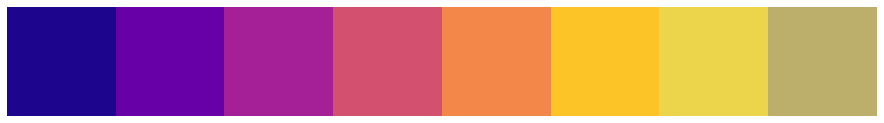

In [342]:
plt.figure(figsize = (20,2))
plt.imshow([genre_colors])
plt.axis('off')
plt.show()

# Data Collection 

In [87]:
# params = {
#         "thriller": {"years": ["2020s","2010s", "2000s"],
#                 "sub_years": [["2020", "2021", "2022"],["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"],[[]]]}, 
#         "action": {"years": ["2020s","2010s", "2000s"],
#                 "sub_years": [["2020", "2021", "2022"],["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"],["2000", "2001", "2002","2003","2004","2005","2006","2007","2008","2009"]]},             
#         "comedy": {"years": ["2020s","2010s", "2000s"],
#                 "sub_years": [["2020", "2021", "2022"],["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"],["2000", "2001", "2002","2003","2004","2005","2006","2007"]]},
#         "adventure": {"years": ["2020s","2010s", "2000s"],
#                 "sub_years": [["2020", "2021", "2022", "2023"], ["2010", "2011", "2012","2013","2014","2015","2016","2017","2018","2019"], ["2000", "2001", "2002","2003","2004","2005","2006","2007","2008","2009"]]}, 
#         "horror": {"years": ["2020", "2021", "2022", "2010","2011","2012","2013","2014","2015","2016","2017","2018","2019", "2000", "2001", "2002","2003","2004","2005","2006","2007","2008","2009"], 
#                 "sub_years": [[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[],[]]},
#         "fantasy": {"years": ["2020s","2010s", "2000s"],
#                 "sub_years": [[[]],[[]],[[]]]}, 
#         "science_fiction": {"years": ["2020s", "2010s", "2000s"],
#                 "sub_years": [[[]],[[]],[[]]]}, 
#         }

# data_collection = DataCollection()
# data_movie_artist = pd.DataFrame()
# for genre in params.keys():
#     for years, sub_years in zip(params[genre]["years"],params[genre]["sub_years"]):
#         data = data_collection.collect_movies_artist_data(genre, years, sub_years)
#         data_movie_artist = pd.concat([data_movie_artist, data]) 

# data_movie_artist = data_movie_artist.reset_index(drop=True)

In [343]:
data_movie_artist = pd.read_json('data_movie_artist.json', orient='table')
data_movie_artist.shape

(7456, 7)

# Data Cleaning

In [344]:
# data_cleaner = DataCleaning(data_movie_artist)
# data_cleaner.data_cleaning()
# df_movies = data_cleaner.data

In [345]:
df_movies = pd.read_json('df_movies.json', orient='table')
df_movies.shape

(5780, 7)

# Get Ratings

In [346]:
# # Initialize the IMDb object
# ia = IMDb()

# # Function to get movie rating
# def get_movie_rating(title):
#     try:
#         movie = ia.search_movie(title)[0]  # Assume the first search result is the correct movie
#         ia.update(movie)
#         return movie.data['rating']
#     except Exception as e:
#         return None

# # Add a new column to the DataFrame with the ratings
# df_movies['Rating'] = df_movies['Title'].apply(get_movie_rating)

In [347]:
df_movies_ratings = pd.read_json('with_ratings.json', orient='table')
df_movies_ratings.shape

(5780, 8)

In [348]:
# Movies without rating
print(df_movies_ratings['Rating'].isnull().sum())
# we drop them
df_movies_ratings = df_movies_ratings.dropna()

428


In [357]:
percentile_25 = df_movies_ratings['Rating'].quantile(0.25) 
print(percentile_25)
percentile_75 = df_movies_ratings['Rating'].quantile(0.75)
print(percentile_75)

5.2
6.8


In [360]:
# Function to apply the conditions
def label_rating(row):
    if row < percentile_25:
        return 'Low'
    elif row >= percentile_75:
        return 'High'
    else:
        return 'Moderate'

# Apply the function to create a new column
df_movies_ratings['RatingLabel'] = df_movies_ratings['Rating'].apply(label_rating)

In [361]:
def categorize_year(year):
    if "2000" <= year <= "2009":
        return "00-09"
    elif "2010" <= year <= "2019":
        return "10-19"
    else:
        return "20-29"

# Apply the function to create a new column
df_movies_ratings['Decade'] = df_movies_ratings['Year'].apply(categorize_year)

In [352]:
df_movies_ratings = pd.read_json('df_movies_ratings.json', orient='table')
df_movies_ratings.shape

(5352, 9)

In [362]:
df_movies_ratings.head(2)

,Title,Director,Cast,Country,Genre,Year,Hyperref,Rating,RatingLabel,Decade
0,365 Days,barbara biaowas tomasz mandes,"anna-maria sieklucka,michele morrone, bronisaw...",europe,Thriller,2020,365_Days_(2020_film),3.3,Low,20-29
1,7500,patrick vollrath,"joseph gordon-levitt,aylin tezel",mix,Action,2020,7500_(film),6.3,Moderate,20-29


In [363]:
df_movies_ratings['RatingLabel'].value_counts()

Moderate    2711
High        1416
Low         1225
Name: RatingLabel, dtype: int64

______

In [423]:
def plot_bar(x, y, data, title, xlabel, ylabel, figsize, color_palette, rotation=False): 
    # Create the bar plot
    sns.set(style="white") 
    plt.figure(figsize=figsize) 
    barplot = sns.barplot(x=x, y=y, data=data, palette=color_palette)

    # Rotate the labels on x-axis for better readability
    if rotation: 
        plt.xticks(rotation=45, ha='right', fontsize=13)
    else: 
        plt.xticks(fontsize=13)
    plt.title(title, fontsize=20)
    plt.xlabel(xlabel, fontsize=16)
    plt.ylabel(ylabel, fontsize=16)

    total = sum(p.get_height() for p in barplot.patches)
    for p in barplot.patches:
        percentage = f'{100 * p.get_height() / total:.1f}%'  # Format as a percentage with one decimal
        barplot.annotate(percentage,
                        (p.get_x() + p.get_width() / 2., p.get_height()),
                        ha='center', va='center',
                        xytext=(0, 4),
                        textcoords='offset points',
                        fontsize=13)
    plt.show()

# Basic Statistics

### Rating distribution

In [444]:
colorpalette[3]

(0.248032, 0.014439, 0.612868)

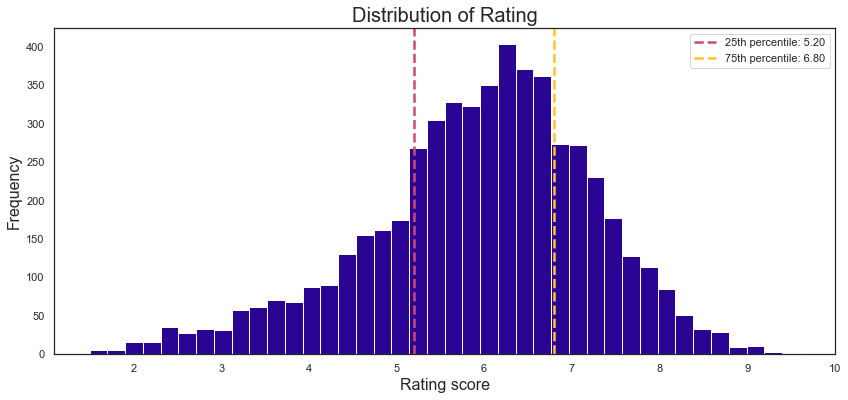

In [456]:
# Plot the histogram using matplotlib
plt.figure(figsize=(14,6))
plt.hist(list(df_movies_ratings['Rating'].values), bins=40, edgecolor='white', color=colorpalette[1])
plt.xlabel('Rating score', fontsize=16)
plt.ylabel('Frequency',fontsize=16)
plt.title('Distribution of Rating', fontsize=20)

# Add vertical lines for mean and median
percentile_25 = np.percentile(list(df_movies_ratings['Rating'].values), 25)
percentile_75 = np.percentile(list(df_movies_ratings['Rating'].values), 75)
plt.axvline(percentile_25, color=colorpalette[20], linestyle="dashed", linewidth=2.5, label=f"25th percentile: {percentile_25:.2f}")
plt.axvline(percentile_75, color=colorpalette[35], linestyle="dashed", linewidth=2.5, label=f"75th percentile: {percentile_75:.2f}")
    
# Add a legend
plt.legend()

plt.show()

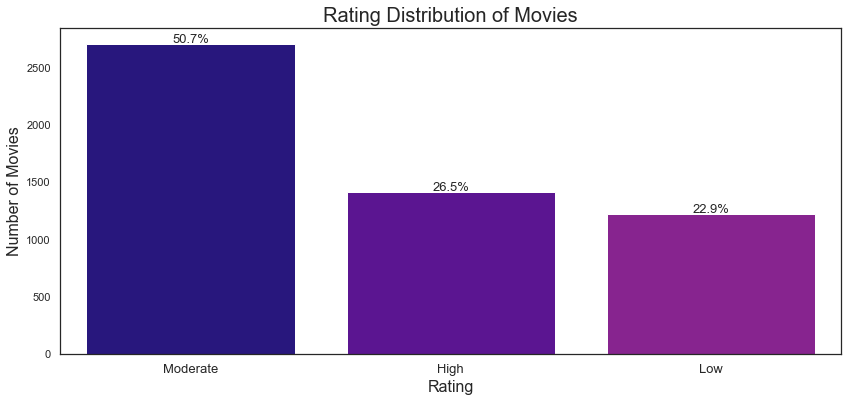

In [424]:
rating_counts = df_movies_ratings['RatingLabel'].value_counts()
rating_counts = rating_counts.reset_index()
rating_counts.columns = ['RatingLabel', 'Count']
plot_bar(x = 'RatingLabel', y = 'Count', data = rating_counts, title = 'Rating Distribution of Movies', 
         xlabel= 'Rating', ylabel= 'Number of Movies', figsize=(14,6), 
         color_palette=three_ratings_colors)

### Genre distribution

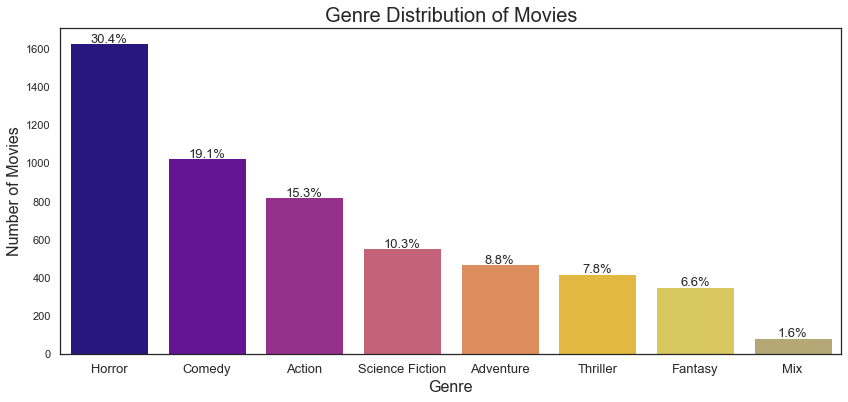

In [408]:
genre_counts = df_movies_ratings['Genre'].value_counts()
genre_counts = genre_counts.reset_index()
genre_counts.columns = ['Genre', 'Count']
plot_bar(x ='Genre', y='Count', data=genre_counts, title='Genre Distribution of Movies', 
         xlabel='Genre', ylabel = 'Number of Movies', figsize=(14,6), color_palette=genre_colors)

### Movies over time 

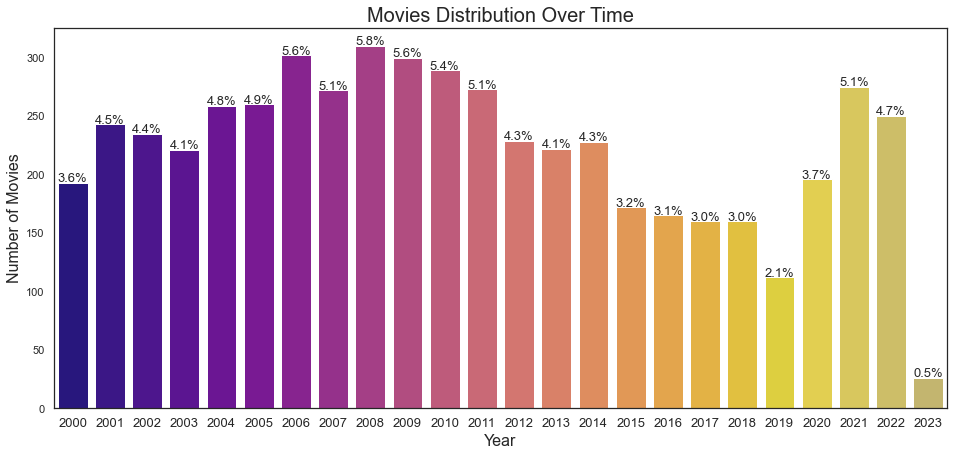

In [420]:
df_movies_ratings['Year'] = pd.to_numeric(df_movies_ratings['Year'], errors='coerce')
movies_per_year = df_movies_ratings.groupby('Year').size()
movies_per_year = movies_per_year.reset_index()
movies_per_year.columns = ['Year', 'Number of Movies']
plot_bar(x ='Year', y='Number of Movies', data=movies_per_year, title='Movies Distribution Over Time', 
         xlabel='Year', ylabel = 'Number of Movies', figsize=(16,7), color_palette=colorpalette[::2])

### Country distribution

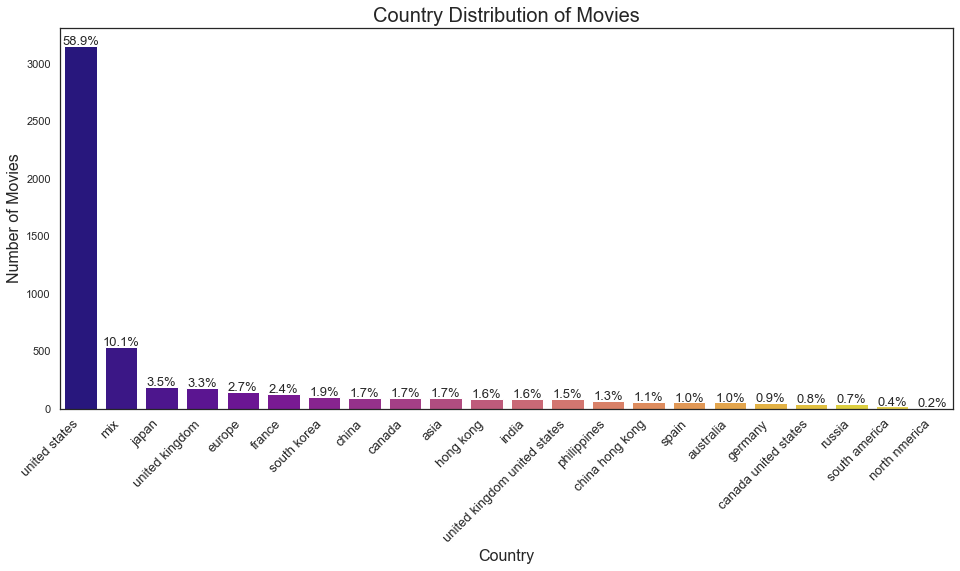

In [425]:
country_counts = df_movies_ratings['Country'].value_counts()
country_counts = country_counts.reset_index()
country_counts.columns = ['Country', 'Count']
plot_bar(x ='Country', y='Count', data=country_counts, title='Country Distribution of Movies', 
         xlabel='Country', ylabel = 'Number of Movies', figsize=(16,7), color_palette=colorpalette[::2], rotation=True)



____________


# Network Science

## Get connections between Movies and Artists

In [ ]:
# get_connected_movies_artists = GetConnectedMoviesArtist()
# connected_movies = get_connected_movies_artists.connected_movies_and_cast(df_movies_ratings)
# with open('connected_movies_and_casts.json', 'w') as file:
#     json.dump(connected_movies, file, indent=4)
with open('connected_movies_and_casts.json', 'r') as file:
    connected_movies = json.load(file)
len(connected_movies.keys())

## Create Network and add attributes

In [251]:
# Create undirected Graph
G_movies = nx.Graph()

# Adding nodes
movies_nodes = list(connected_movies.keys())
G_movies.add_nodes_from(movies_nodes)

node_attr = df_movies_ratings[['Title','Director','Cast','Country','Genre', 'RatingLabel',
                'Year', 'Decade']].set_index('Title').to_dict('index') # Creating a dictionary with the characters and their attributes

nx.set_node_attributes(G_movies, node_attr) #Adding attributes to the graph

for movie in connected_movies.keys():
    for connected_movie in connected_movies[movie]: 
        weight = len(connected_movies[movie][connected_movie])
        attribute_value = connected_movies[movie][connected_movie]
        G_movies.add_edges_from([(movie, connected_movie)], weight=weight, attribute_name=attribute_value)

In [221]:
print(G_movies.edges["365 Days: This Day", "365 Days"])

{'weight': 3, 'attribute_name': ['magdalena lamparska', 'michele morrone', 'anna-maria sieklucka']}


In [222]:
print(G_movies.nodes["365 Days: This Day"])

{'Director': 'barbara biaowas,tomasz mandes', 'Cast': 'anna-maria sieklucka,michele morrone, rebecca casiraghi,magdalena lamparska', 'Country': 'europe', 'Genre': 'Thriller', 'RatingLabel': 'Low', 'Year': '2022'}


In [194]:
print("The network consist of: ", G_movies.number_of_nodes(), " nodes (Movies)")
print("The network consist of: ", G_movies.number_of_edges(), " edges")

The network consist of:  5352  nodes (Movies)
The network consist of:  34122  edges


## Get Largest Connected Component

In [252]:
#Extracting the largest component
connected_components = nx.connected_components(G_movies)
# Finding the largest connected component
largest_cc = max(connected_components, key=len)
# Creating a subgraph for the largest connected component
G_largest_cc = G_movies.subgraph(largest_cc).copy()

In [250]:
print("The largest connected component network consist of: ", G_largest_cc.number_of_nodes(), " nodes (Movies)")
print("The largest connected component network consist of: ", G_largest_cc.number_of_edges(), " edges")

The largest connected component network consist of:  4029  nodes (Movies)
The largest connected component network consist of:  33730  edges


## Plot Network JOJO color after RatingLabels
- if time do also for genre, but not important for now

# Assortativity analysis 

In [249]:
nx.degree_assortativity_coefficient(G_largest_cc)

0.33712467636528853

In [253]:
nx.attribute_assortativity_coefficient(G_largest_cc, 'Genre')

0.14011725941445055

In [240]:
nx.attribute_assortativity_coefficient(G_largest_cc, 'RatingLabel')

0.07406899877737227

In [239]:
nx.attribute_assortativity_coefficient(G_largest_cc, 'Decade')

0.11670078205832192

### Permutation test of degress

- Shuffling edges while preserving node degrees. This process allows you to assess whether the observed degree assortativity coefficient is significant or could have occurred by random chance.
- Shuffle Edges: Randomly rewire the edges in the network while preserving the degree of each node. This can be done using the nx.double_edge_swap function, which randomly swaps the edges in the graph but keeps the degree sequence the same.
- Compute Assortativity for Each Permutation: Calculate the degree assortativity coefficient for each of these rewired graphs.


In [264]:
original_coefficient = nx.degree_assortativity_coefficient(G_largest_cc)

# Number of permutations
n_permutations = 1000
permuted_coefficients = []

# Make a copy of the original graph for permutation
G_permuted = G_largest_cc.copy()

for _ in range(n_permutations):
    # Perform edge swaps to shuffle the graph while preserving degree sequence
    G_shuffled = nx.double_edge_swap(G_permuted, nswap=10*len(G_permuted.edges()), max_tries=50*len(G_permuted.edges()))

    # Calculate degree assortativity coefficient for the shuffled graph
    coeff = nx.degree_assortativity_coefficient(G_shuffled)
    permuted_coefficients.append(coeff)

# Calculate the p-value
p_value = sum(1 for coeff in permuted_coefficients if coeff >= original_coefficient) / n_permutations

print(f"Original Coefficient: {original_coefficient}")
print(f"P-Value: {p_value}")


Original Coefficient: 0.33712467636528853
P-Value: 0.0


### Permutation test of Rating

In [262]:
# Assuming G_largest_cc is your original graph
original_coefficient = nx.attribute_assortativity_coefficient(G_largest_cc, 'RatingLabel')

# Number of permutations
n_permutations = 1000
permuted_coefficients = []

for _ in range(n_permutations):
    # Shuffle the Rating attribute among nodes
    G_permu = G_largest_cc.copy()
    genres = [G_permu.nodes[n]['RatingLabel'] for n in G_permu.nodes()]
    np.random.shuffle(genres)
    
    # Assign the shuffled genres back to the nodes
    for n, genre in zip(G_permu.nodes(), genres):
        G_permu.nodes[n]['RatingLabel'] = genre
    
    # Calculate assortativity coefficient for the permuted graph
    coeff = nx.attribute_assortativity_coefficient(G_permu, 'RatingLabel')
    permuted_coefficients.append(coeff)

# Calculate the p-value
p_value = sum(1 for coeff in permuted_coefficients if coeff >= original_coefficient) / n_permutations
# (np.sum([result >= original_coefficient for result in permuted_coefficients]) + 1) / (1000 + 1)

print(f"Original Coefficient: {original_coefficient}")
print(f"P-Value: {p_value}")

if p_value <= 0.05:
    print(f"significant")
else:
    print(f"There is no significant difference")

Original Coefficient: 0.07406899877737227
P-Value: 0.0
significant


### Permutation test of Genre

In [256]:
# Assuming G_largest_cc is your original graph
original_coefficient = nx.attribute_assortativity_coefficient(G_largest_cc, 'Genre')

# Number of permutations
n_permutations = 1000
permuted_coefficients = []

for _ in range(n_permutations):
    # Shuffle the Genre attribute among nodes
    G_permu = G_largest_cc.copy()
    genres = [G_permu.nodes[n]['Genre'] for n in G_permu.nodes()]
    np.random.shuffle(genres)
    
    # Assign the shuffled genres back to the nodes
    for n, genre in zip(G_permu.nodes(), genres):
        G_permu.nodes[n]['Genre'] = genre
    
    # Calculate assortativity coefficient for the permuted graph
    coeff = nx.attribute_assortativity_coefficient(G_permu, 'Genre')
    permuted_coefficients.append(coeff)

# Calculate the p-value
p_value = sum(1 for coeff in permuted_coefficients if coeff >= original_coefficient) / n_permutations
# (np.sum([result >= original_coefficient for result in permuted_coefficients]) + 1) / (1000 + 1)

print(f"Original Coefficient: {original_coefficient}")
print(f"P-Value: {p_value}")

if p_value <= 0.05:
    print(f"significant")
else:
    print(f"There is no significant difference")


Original Coefficient: 0.14011725941445055
P-Value: 0.0


### Permutation test of Decade

In [263]:
original_coefficient = nx.attribute_assortativity_coefficient(G_largest_cc, 'Decade')

# Number of permutations
n_permutations = 1000
permuted_coefficients = []

for _ in range(n_permutations):
    # Shuffle the Year attribute among nodes
    G_permu = G_largest_cc.copy()
    genres = [G_permu.nodes[n]['Decade'] for n in G_permu.nodes()]
    np.random.shuffle(genres)
    
    # Assign the shuffled genres back to the nodes
    for n, genre in zip(G_permu.nodes(), genres):
        G_permu.nodes[n]['Decade'] = genre
    
    # Calculate assortativity coefficient for the permuted graph
    coeff = nx.attribute_assortativity_coefficient(G_permu, 'Decade')
    permuted_coefficients.append(coeff)

# Calculate the p-value
p_value = sum(1 for coeff in permuted_coefficients if coeff >= original_coefficient) / n_permutations
# (np.sum([result >= original_coefficient for result in permuted_coefficients]) + 1) / (1000 + 1)

print(f"Original Coefficient: {original_coefficient}")
print(f"P-Value: {p_value}")

if p_value <= 0.05:
    print(f"significant")
else:
    print(f"There is no significant difference")


Original Coefficient: 0.11670078205832192
P-Value: 0.0
significant


# Communities 

In [137]:
communities = cl.best_partition(G_largest_cc, random_state=42)

In [139]:
print('The algorithm found', len(np.unique(list(communities.values()))), 'communities in total')

The algorithm found 28 communities in total


In [140]:
modularity = community.modularity(communities, G_largest_cc)
print('The value of modularity is:', round(modularity,2))

The value of modularity is: 0.55


In [143]:
community_count

9     311
22    287
0     261
21    232
11    180
4     178
17    175
1     171
18    163
3     158
26    157
13    143
8     140
15    140
5     135
16    124
6     122
10    120
12    120
14    115
25    109
23    105
19     99
7      96
24     68
2      58
20     38
27     24
dtype: int64

In [142]:
# Count number of rappers in each comunity
community_count = pd.Series(list(communities.values())).value_counts()

# Plot the distribution of community with size of nodes
plt.figure(figsize = (16,6))
#plt.bar(community_count.index, community_count.values, color ='blue')
plt.bar(community_count.index, community_count.values, align='center')
# Count the nodes in community
for index, value in zip(community_count.index, community_count.values):
    plt.text(index, value+0.1, str(value), ha='center', va='bottom')

    
plt.ylabel('Number of nodes (rappers) in  each community')
plt.xlabel('Community number')
plt.title('Distribution of nodes (rappers) in the communities', fontweight="bold") #fontsize=16, 
plt.suptitle("Figure 7", fontsize=16, fontweight="bold")
plt.xticks(community_count.index)

plt.show()

ImportError: cannot import name '_png' from 'matplotlib' (/opt/anaconda3/lib/python3.8/site-packages/matplotlib/__init__.py)

<Figure size 1152x432 with 1 Axes>